In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pymc as pm
from pymc.ode import DifferentialEquation

from itertools import product
import os.path as osp
from scipy.optimize import leastsq
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import math
import time
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
from IPython.display import display as print
from datetime import datetime
from scipy.integrate import odeint

# import sunode
import pickle

import core


In [7]:
db_csv_path = "dataset/data.csv"
idata_save_path = "odes-exp04-idata-4-number-1core-halfnormsco-halfnormks-from-core.py-success.dt"

dataset_ori = core.MyDataset(db_csv_path)
df_ori = dataset_ori.get_df()
cct_names, rates_names, error_names = dataset_ori.get_var_col_names()
c0 = df_ori[cct_names].iloc[0].values


/Users/izhangxm/WorkStation/PycharmProjects/N15Tracing/core.py:269: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


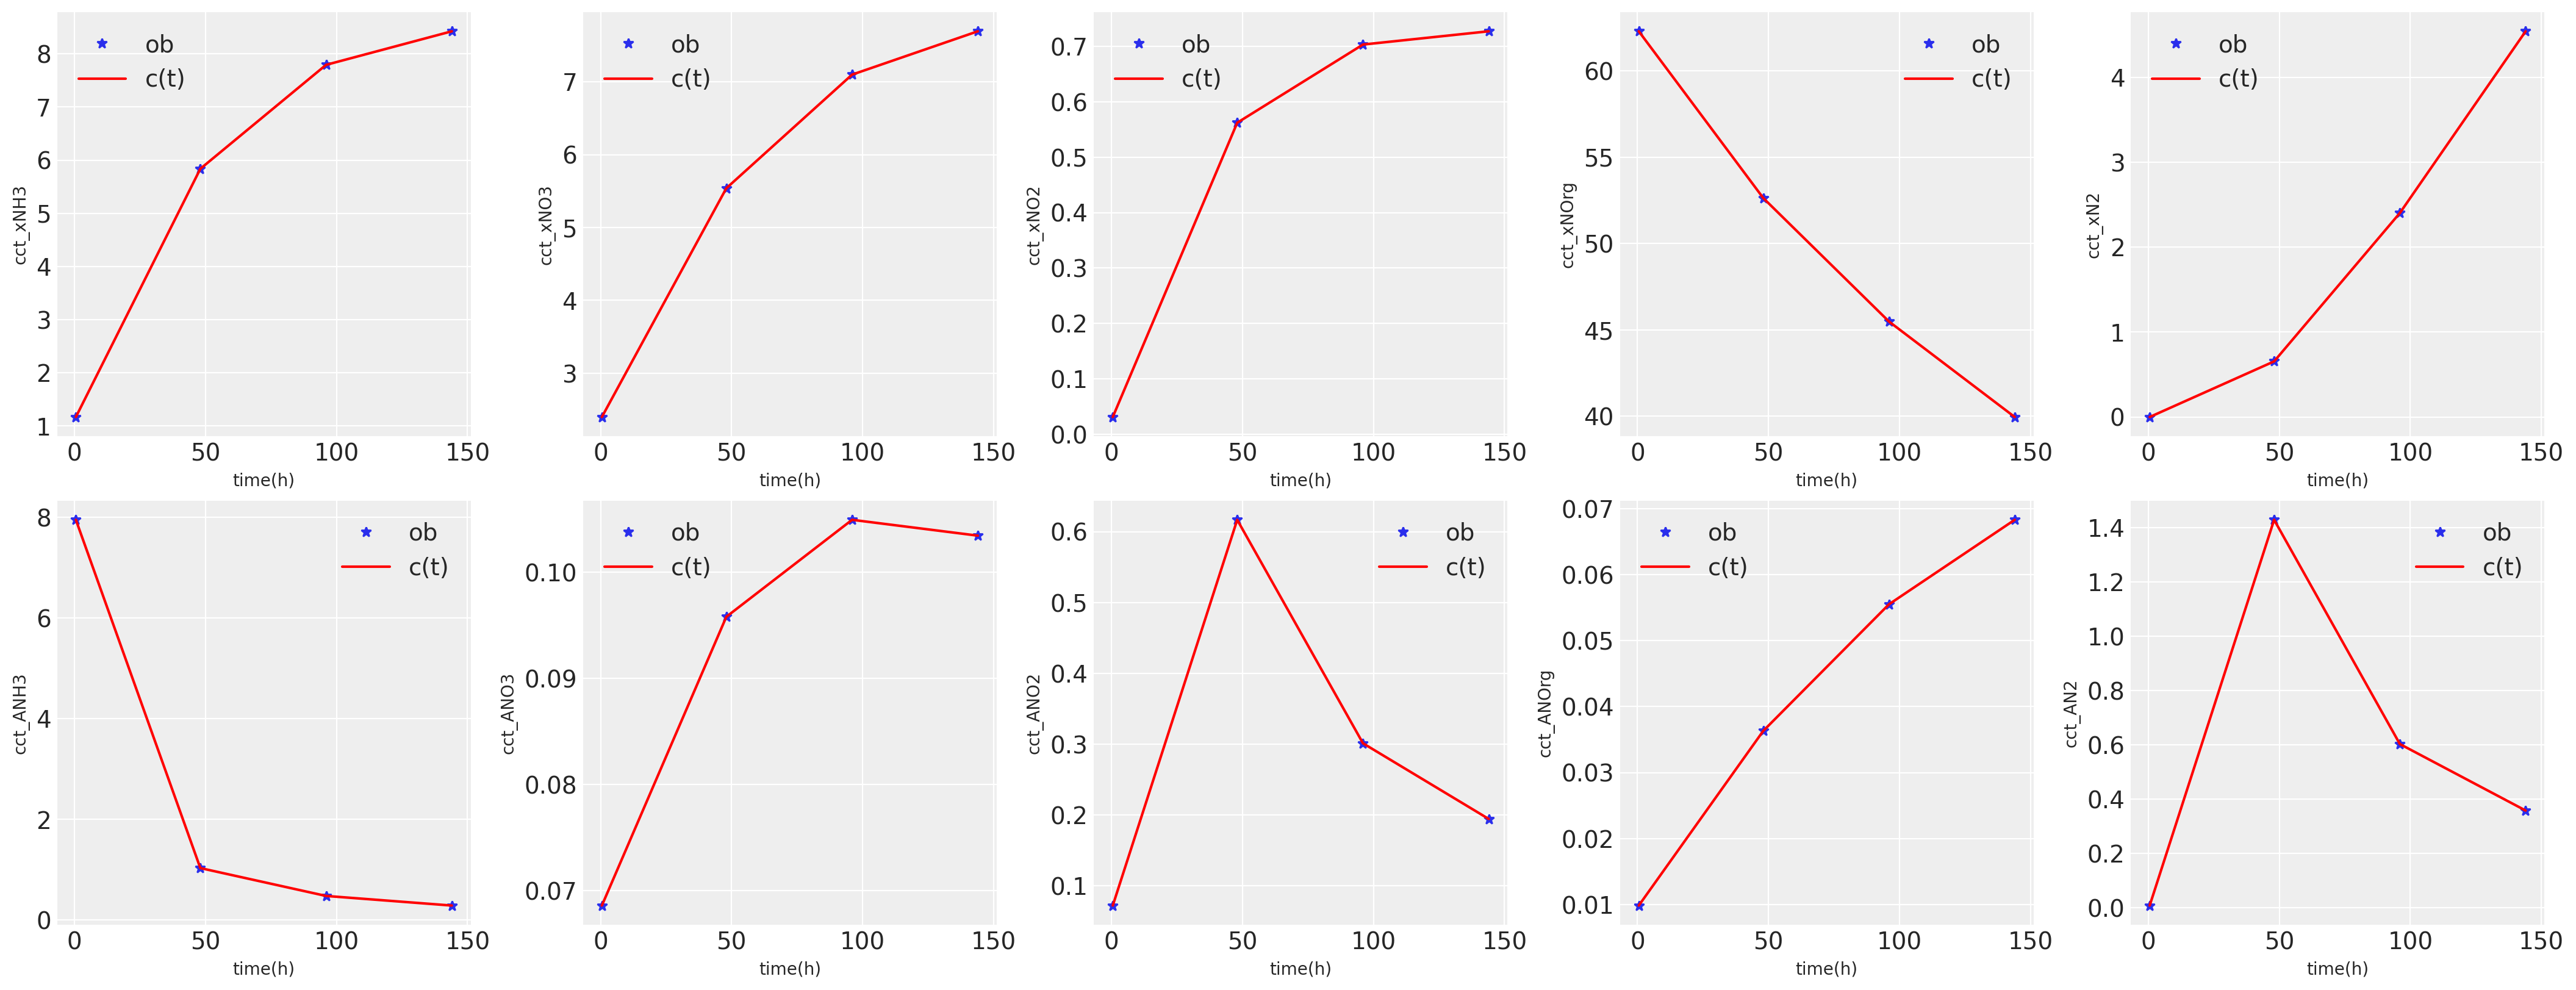

In [8]:
# 假设都是一级动力学
k_kinetics = np.repeat(1, 11).astype(np.uint8) 
# k_kinetics = np.array([0,0,0,0,1,1,0,0,1,1,0]).astype(np.uint8) 
ks = np.array([0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299, 0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432, 0.00177611])
#  =======================================================

# t_eval = np.linspace(0.5, 150, 8)
t_eval = np.array([0.5, 48, 96, 144])


dataset = core.MyDataset(db_csv_path)
df = dataset.get_df()
cct_names, rates_names, error_names = dataset.get_var_col_names()
c0 = df[cct_names].iloc[0].values
dataset.set_as_sim_dataset(core.dcdt_func_for_odeint, t_eval, c0, args=(ks, k_kinetics))
df = dataset.get_df()

core.plot_dataset(dataset, dataset)

In [9]:
mcmc_model = core.get_model(dataset, t_eval, k_kinetics, distance=core.distance_func, epsilon=core.epsilon, k_sigma_priors=0.01, kf_type=0)

[xNH3_s, xNO3_s, xNO2_s, xNOrg_s, xN2_s, ANH3_s, ANO3_s, ANO2_s, ANOrg_s, AN2_s]


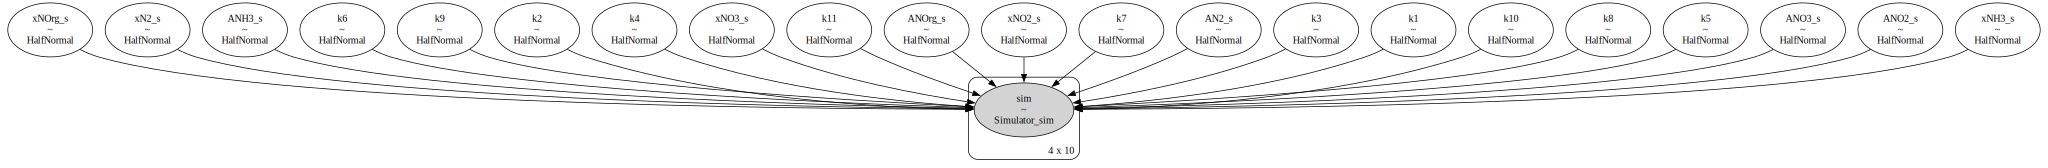

In [10]:
# print(get_format_time(),idata_save_path)
# print(ks, c0)
pm.model_to_graphviz(mcmc_model)

In [ ]:
# print(idata_save_path)
# idata_lv = pickle.load(open(idata_save_path, 'rb'))
# 
idata_lv = pm.sample_smc(draws=2000, chains=1, model=mcmc_model, progressbar=False)
pickle.dump(idata_lv,open(idata_save_path, 'wb'))

In [9]:
# az.plot_trace(idata_lv, kind="rank_vlines");
df[cct_names]

,xNH3,xNO3,xNO2,xNOrg,xN2,ANH3,ANO3,ANO2,ANOrg,AN2
0,1.166667,2.398810,0.031100,62.285000,0.000071,7.948635,0.068579,0.072310,0.009857,0.008320
1,5.837087,5.539301,0.562177,52.633247,0.654953,1.032210,0.095807,0.616771,0.036312,1.427762
2,7.792909,7.098859,0.703303,45.482155,2.402246,0.478821,0.104952,0.301327,0.055499,0.602520
3,8.424422,7.693928,0.727245,39.954070,4.541027,0.288168,0.103458,0.194543,0.068299,0.357938


In [10]:
print(az.summary(idata_lv, round_to=10))
print(ks)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k1,0.004320,0.002023,0.001163,0.006422,0.000941,0.000713,5.657738,4.034935,3.196756
k2,0.005259,0.001014,0.004111,0.006572,0.000463,0.000352,5.237061,7.883195,2.130297
k3,0.005993,0.004030,-0.000393,0.009542,0.001671,0.001330,5.242321,5.686564,2.442039
k4,0.003760,0.000914,0.002806,0.005495,0.000381,0.000285,6.530192,4.546202,1.666083
k5,0.008808,0.003347,0.004971,0.017227,0.001235,0.000948,9.660968,7.990951,2.412275
k6,0.008344,0.001842,0.006737,0.012535,0.000820,0.000617,5.567528,4.512800,1.979308
k7,0.003137,0.002284,-0.000279,0.006468,0.001082,0.000822,4.778703,4.122154,2.551341
k8,0.004584,0.003809,-0.000774,0.009832,0.001843,0.001414,4.546961,5.619084,3.065375
k9,0.004820,0.000513,0.003654,0.005184,0.000188,0.000142,5.465138,11.454939,2.279070
k10,0.002182,0.000298,0.001854,0.002878,0.000120,0.000090,6.095023,4.795503,1.916477


array([0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299,
       0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432,
       0.00177611])

'r2_loss'

0.9974007469007022

/Users/izhangxm/WorkStation/PycharmProjects/N15Tracing/core.py:269: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


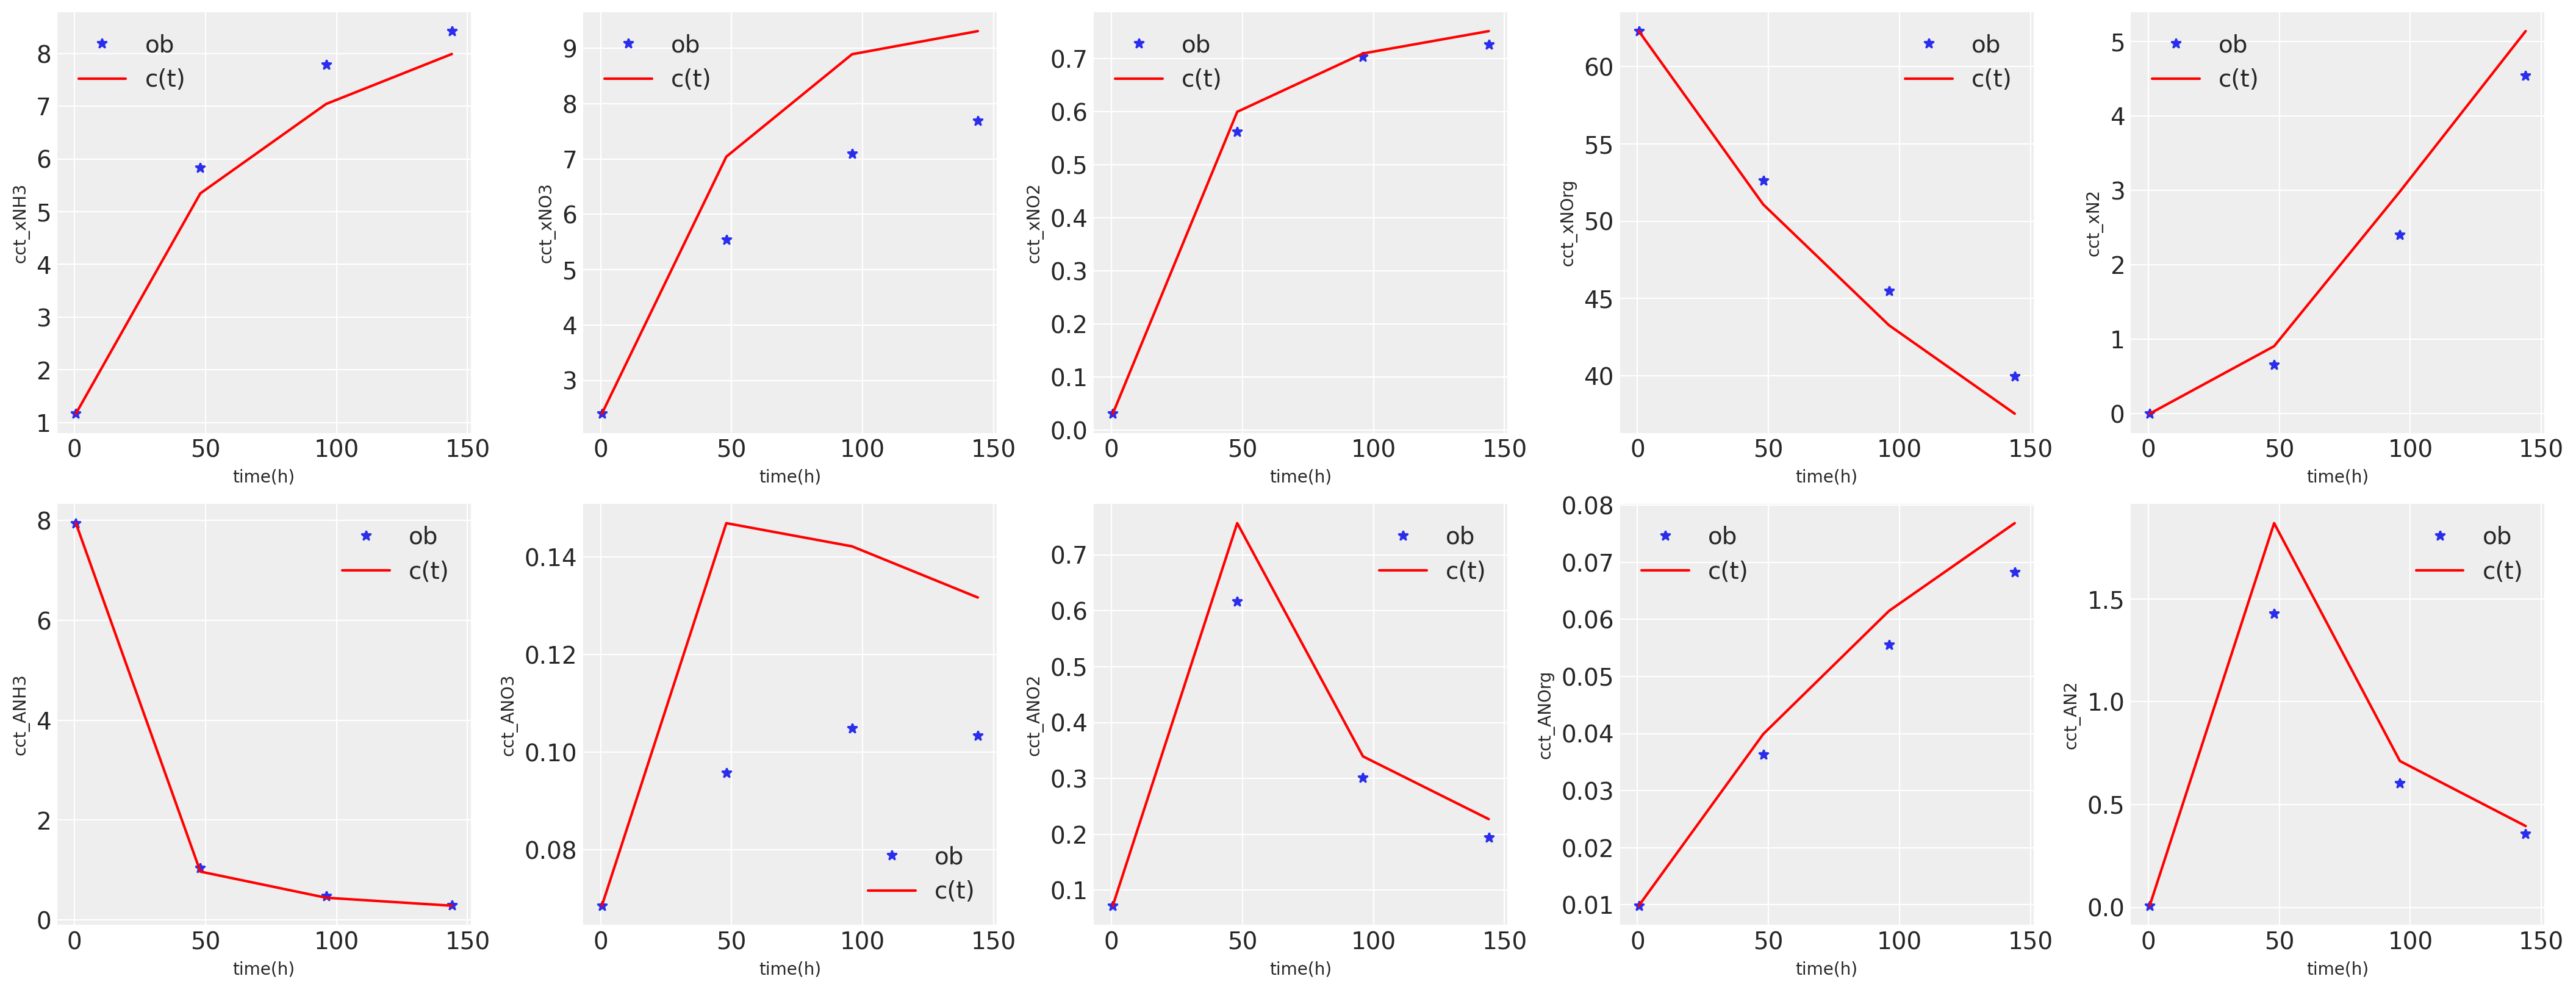

/Users/izhangxm/WorkStation/PycharmProjects/N15Tracing/core.py:269: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


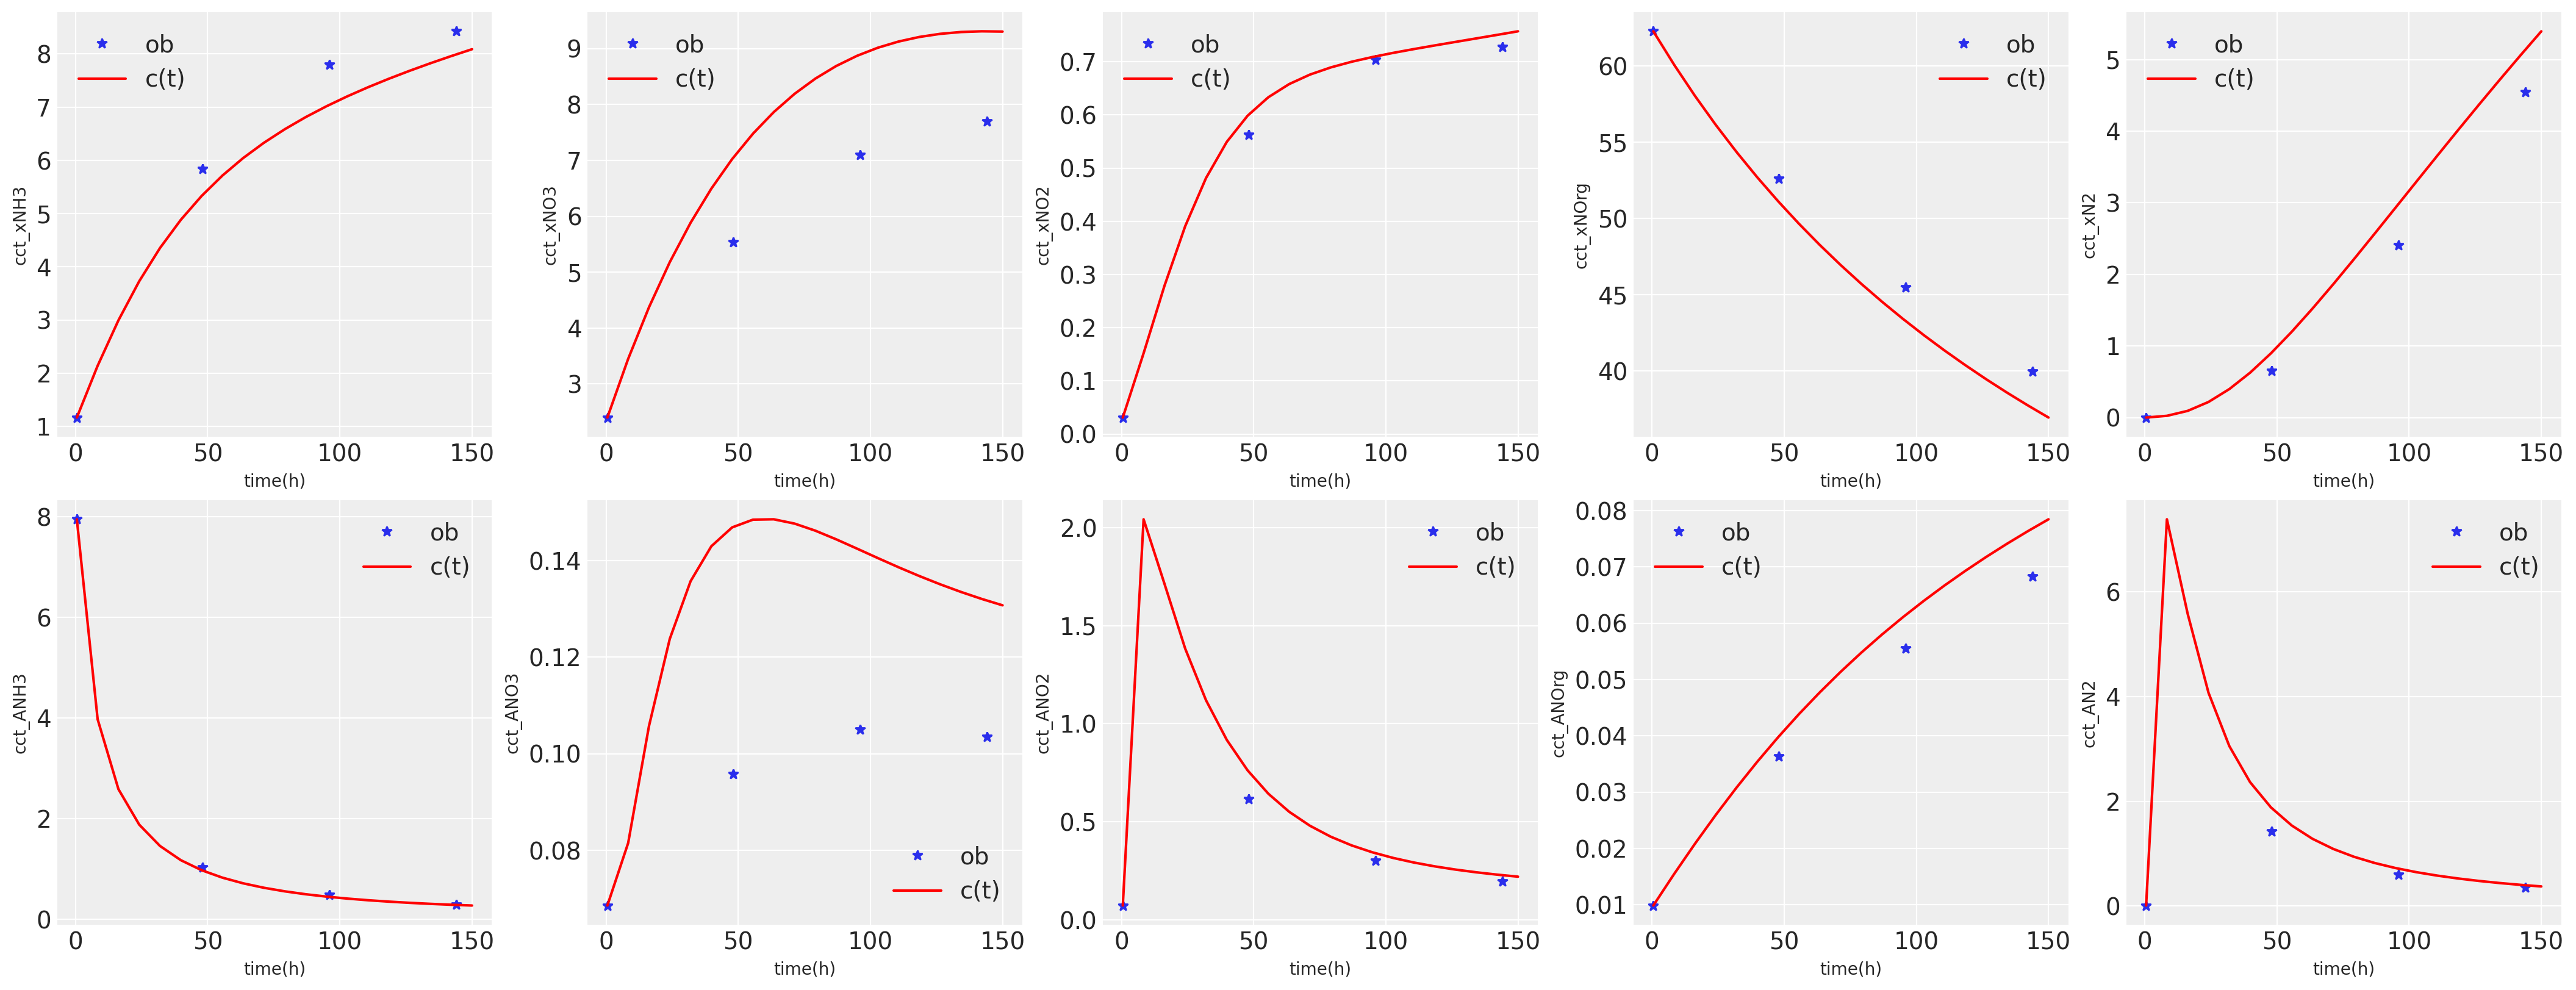

In [11]:
ks_predict = core.get_predict_ks(idata_lv)
k_kinetics = np.repeat(1, 11).astype(np.uint8)
t_eval = np.array([0.5, 48, 96, 144])

dataset_new = core.MyDataset(db_csv_path)
cct_names, rates_names, error_names = dataset_new.get_var_col_names()
gt_s = dataset_new.get_cct()[0]

dataset_new.set_as_sim_dataset(core.dcdt_func_for_odeint, t_eval, gt_s, args=(ks_predict, k_kinetics))

print("r2_loss", core.r2_loss(dataset_new.get_cct(), dataset.get_cct()))
core.plot_dataset(dataset, dataset_new)


t_eval_new = np.linspace(0.5 , 150, 20)
dataset_new2 = core.MyDataset(db_csv_path)
dataset_new2.set_as_sim_dataset(core.dcdt_func_for_odeint, t_eval_new, gt_s, args=(ks_predict, k_kinetics))
core.plot_dataset(dataset, dataset_new2)